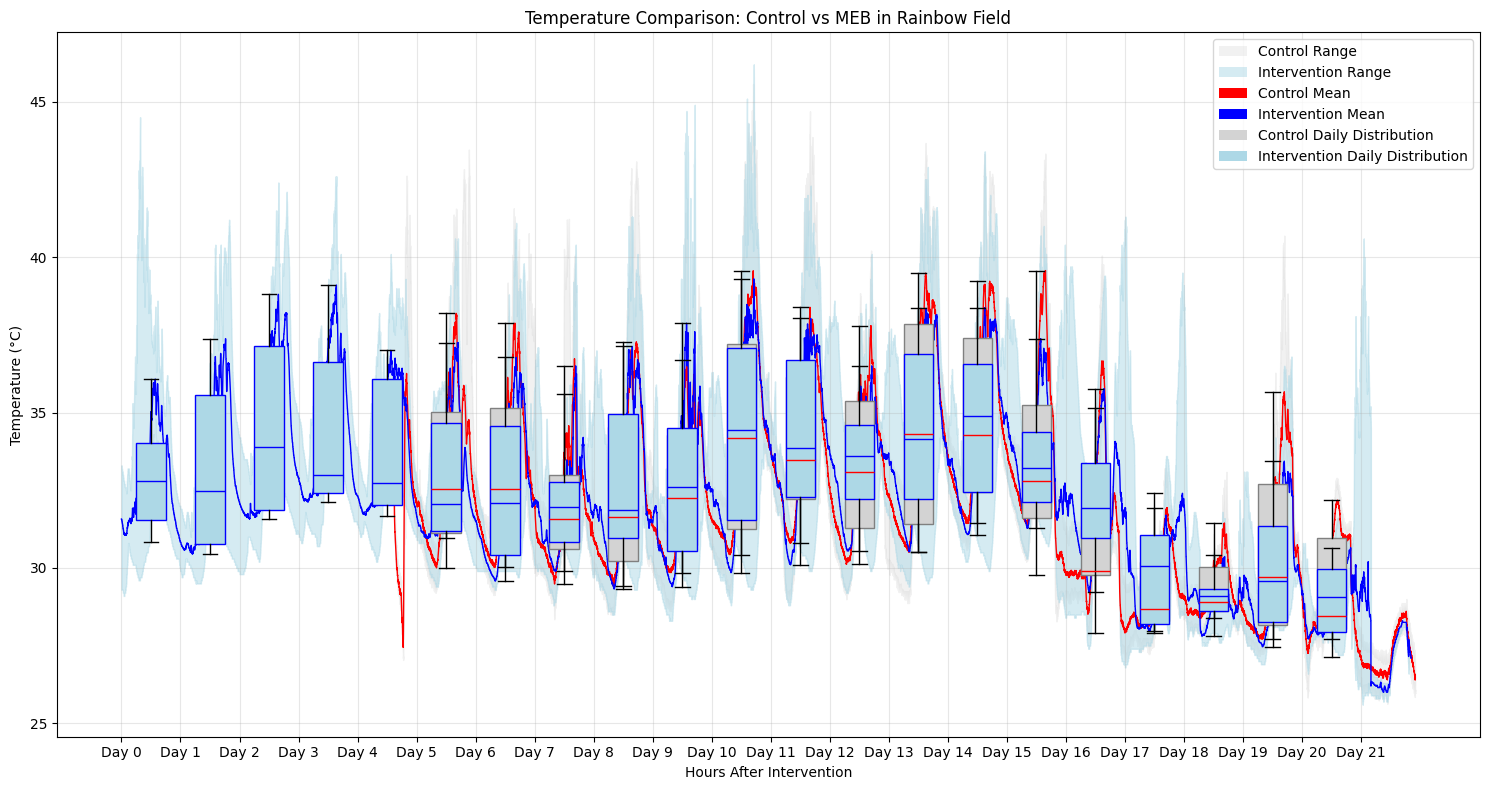

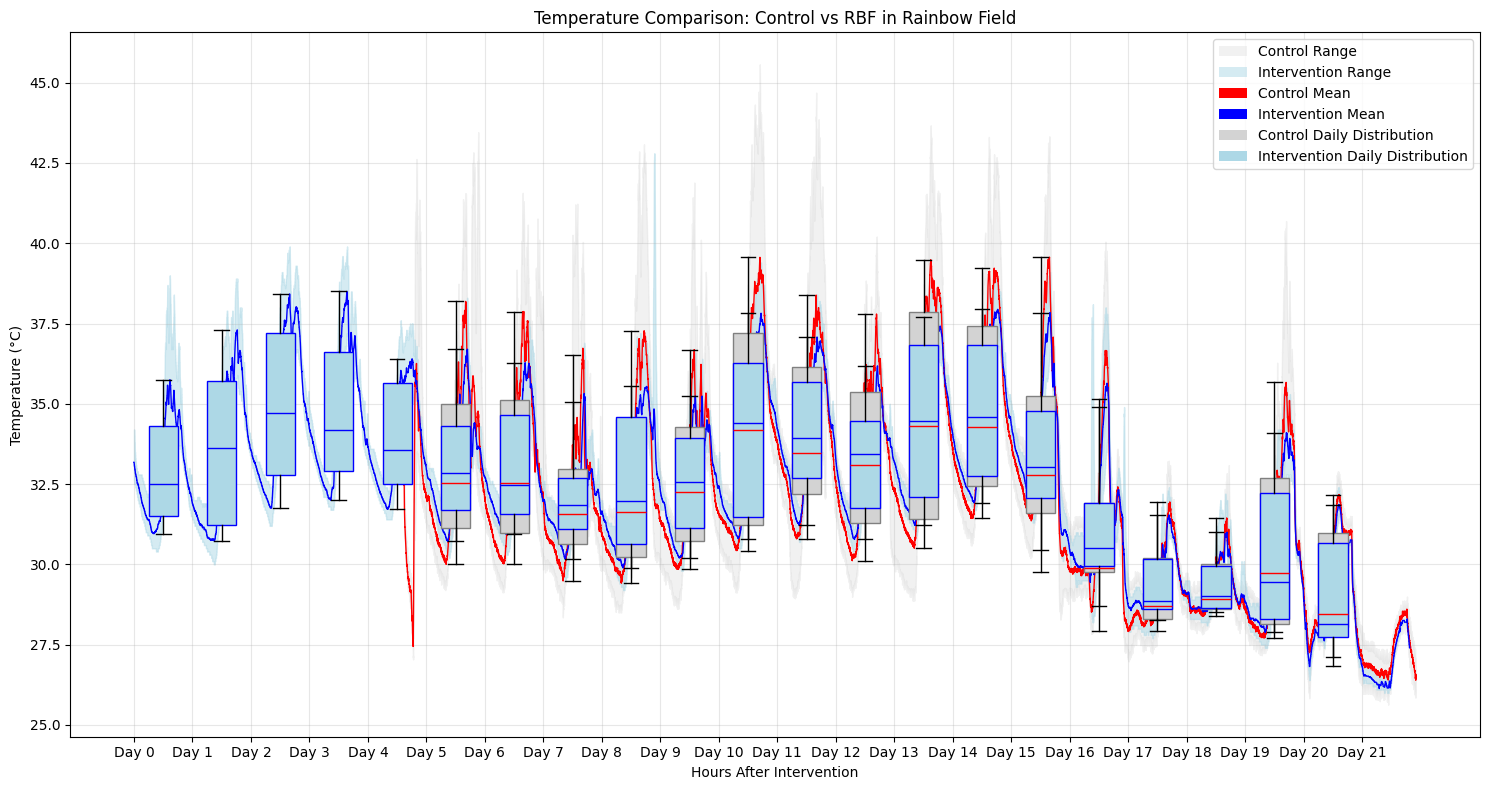

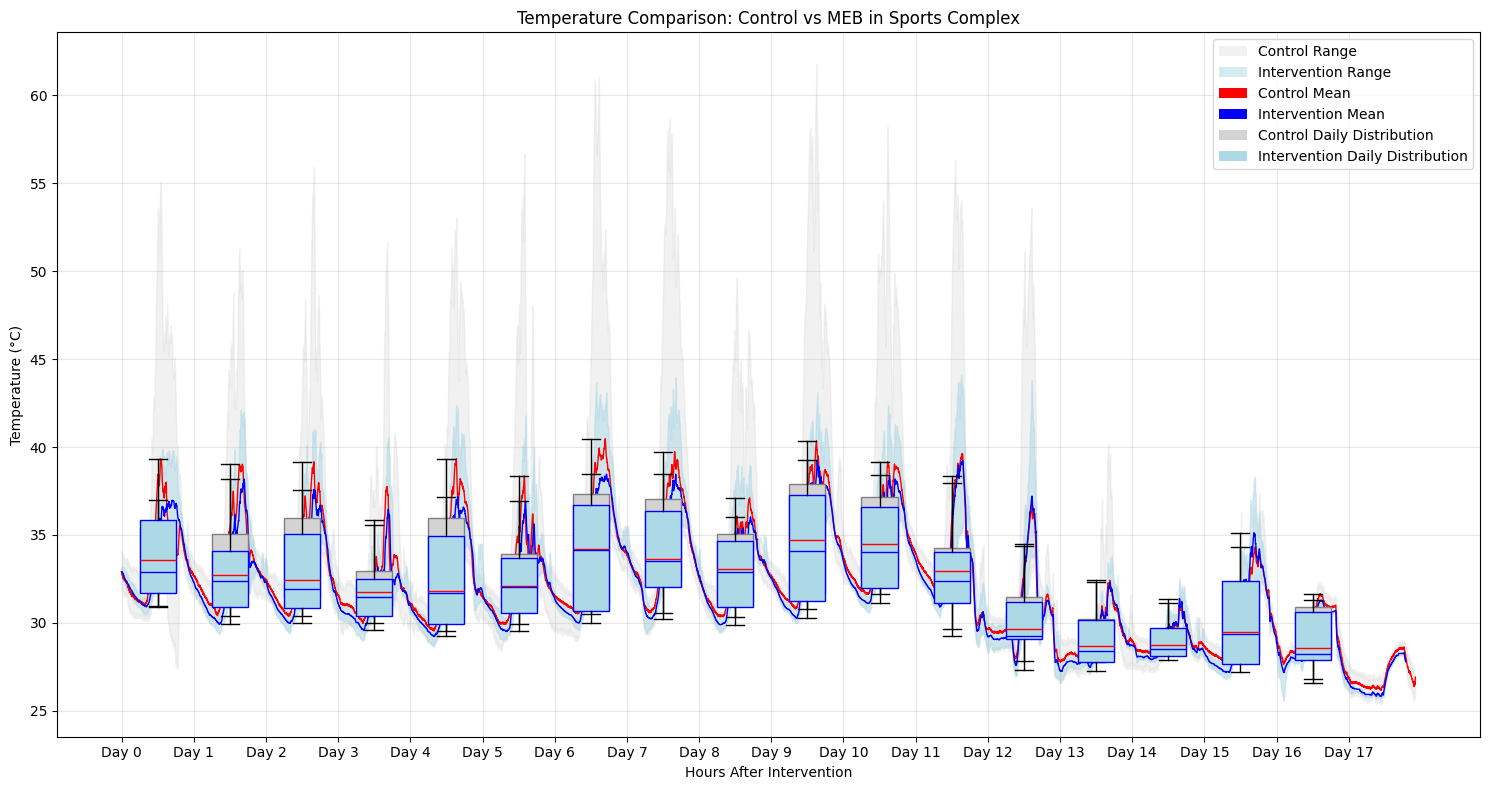

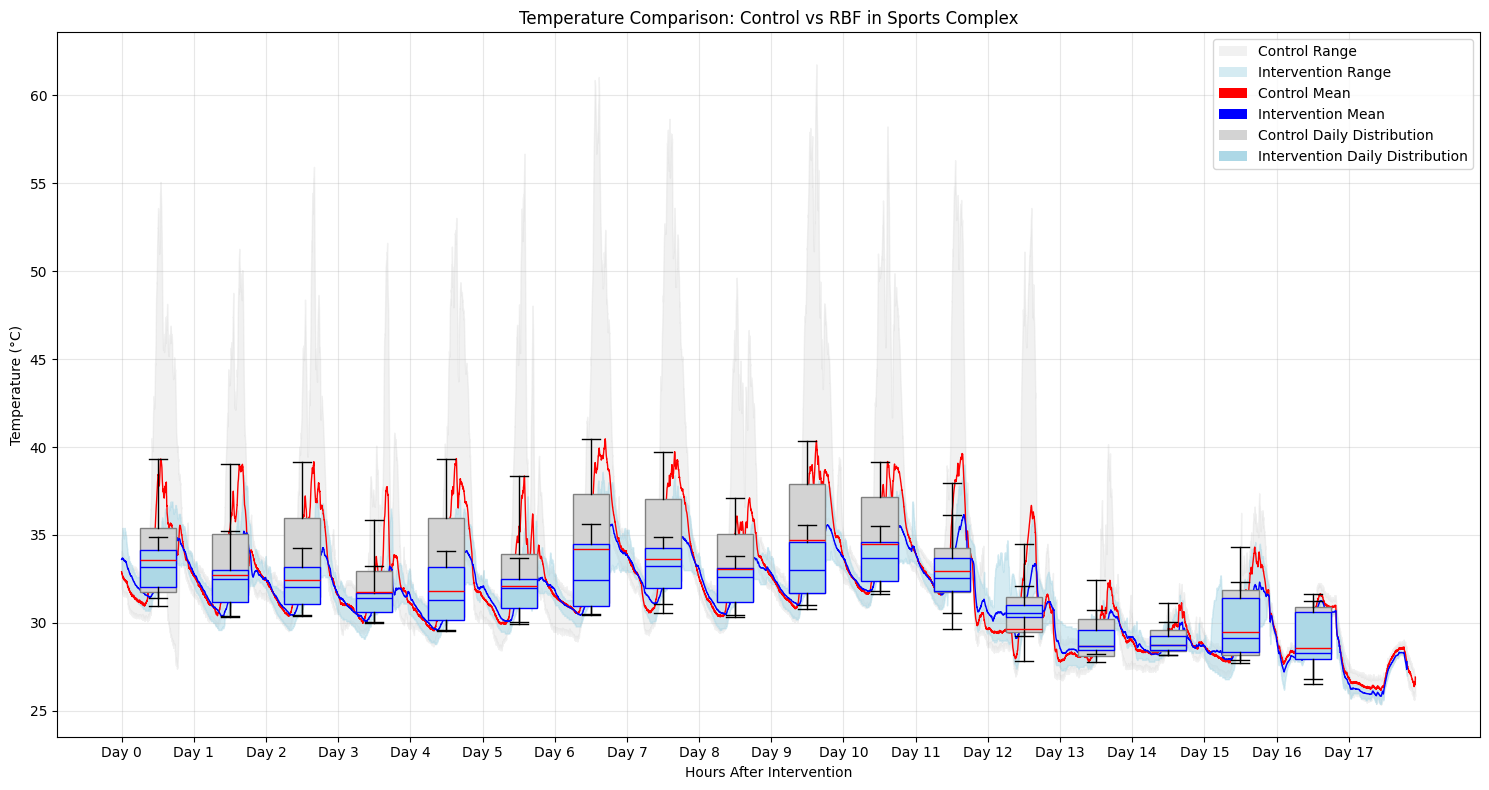

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

master_df = pd.read_csv('master_dataframe.csv', parse_dates=['DateTime'])
logger_flags_df = pd.read_csv('logger_flags.csv')

def create_hourly_comparison_plot(settlement, intervention_type='MEB'):
    control_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) &
        (logger_flags_df['Intervention'] == 'CONTROL')
    ]['Loggers'].tolist()

    intervention_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) &
        (logger_flags_df['Intervention'] == intervention_type)
    ]['Loggers'].tolist()

    intervention_start = pd.to_datetime(
        logger_flags_df[
            (logger_flags_df['Settlement'] == settlement) &
            (logger_flags_df['Intervention'] == intervention_type)
        ]['Intervention_Start'].iloc[0]
    )

    master_df['DateTime'] = pd.to_datetime(master_df['DateTime'])
    post_intervention_df = master_df[master_df['DateTime'] >= intervention_start].copy()
    post_intervention_df['Hours_After_Intervention'] = (
        post_intervention_df['DateTime'] - intervention_start
    ).dt.total_seconds() / 3600

    def calculate_hourly_stats(loggers, df):
        hourly_stats = pd.DataFrame()

        logger_data = df[loggers]
        hourly_stats['max'] = logger_data.max(axis=1)
        hourly_stats['min'] = logger_data.min(axis=1)
        hourly_stats['mean'] = logger_data.mean(axis=1)
        hourly_stats['std'] = logger_data.std(axis=1)
        hourly_stats['Hours_After_Intervention'] = df['Hours_After_Intervention']

        return hourly_stats

    control_stats = calculate_hourly_stats(control_loggers, post_intervention_df)
    intervention_stats = calculate_hourly_stats(intervention_loggers, post_intervention_df)

    plt.figure(figsize=(15, 8))

    plt.fill_between(control_stats['Hours_After_Intervention'],
                     control_stats['max'],
                     control_stats['min'],
                     alpha=0.3,
                     color='lightgray',
                     label='Control Range')

    plt.fill_between(intervention_stats['Hours_After_Intervention'],
                     intervention_stats['max'],
                     intervention_stats['min'],
                     alpha=0.5,
                     color='lightblue',
                     label='Intervention Range')

    plt.plot(control_stats['Hours_After_Intervention'],
             control_stats['mean'],
             color='red',
             label='Control Mean',
             linewidth=1)

    plt.plot(intervention_stats['Hours_After_Intervention'],
             intervention_stats['mean'],
             color='blue',
             label='Intervention Mean',
             linewidth=1)

    box_width = 12
    for day in range(int(max(control_stats['Hours_After_Intervention']) / 24)):
        hour = day * 24

        control_day = control_stats[
            (control_stats['Hours_After_Intervention'] >= hour) &
            (control_stats['Hours_After_Intervention'] < hour + 24)
        ]
        intervention_day = intervention_stats[
            (intervention_stats['Hours_After_Intervention'] >= hour) &
            (intervention_stats['Hours_After_Intervention'] < hour + 24)
        ]

        if len(control_day) > 0:
            plt.boxplot(control_day['mean'],
                       positions=[hour + 12],
                       widths=box_width,
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgray', color='gray'),
                       medianprops=dict(color='red'),
                       showfliers=False)

        if len(intervention_day) > 0:
            plt.boxplot(intervention_day['mean'],
                       positions=[hour + 12],
                       widths=box_width,
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', color='blue'),
                       medianprops=dict(color='blue'),
                       showfliers=False)

    plt.xlabel('Hours After Intervention')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Temperature Comparison: Control vs {intervention_type} in {settlement}')

    legend_elements = [
        Patch(facecolor='lightgray', alpha=0.3, label='Control Range'),
        Patch(facecolor='lightblue', alpha=0.5, label='Intervention Range'),
        Patch(facecolor='red', label='Control Mean'),
        Patch(facecolor='blue', label='Intervention Mean'),
        Patch(facecolor='lightgray', label='Control Daily Distribution'),
        Patch(facecolor='lightblue', label='Intervention Daily Distribution')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    xticks = np.arange(0, max(control_stats['Hours_After_Intervention']), 24)
    plt.xticks(xticks, [f'Day {int(x/24)}' for x in xticks])

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

settlements = ['Rainbow Field', 'Sports Complex']
intervention_types = ['MEB', 'RBF']

for settlement in settlements:
    for intervention_type in intervention_types:
        create_hourly_comparison_plot(settlement, intervention_type)

### Description

The following code generates a plot with interactable legends, colors and modifable hour distributions that allow users to hide or unhide certain elements of the graph.

### Instructions

1. Copy the above code into a new Python file, for example, `interactive_plot.py`.
2. Run the script to generate the plot.
3. Click on the legend items to hide or unhide the corresponding plot lines.

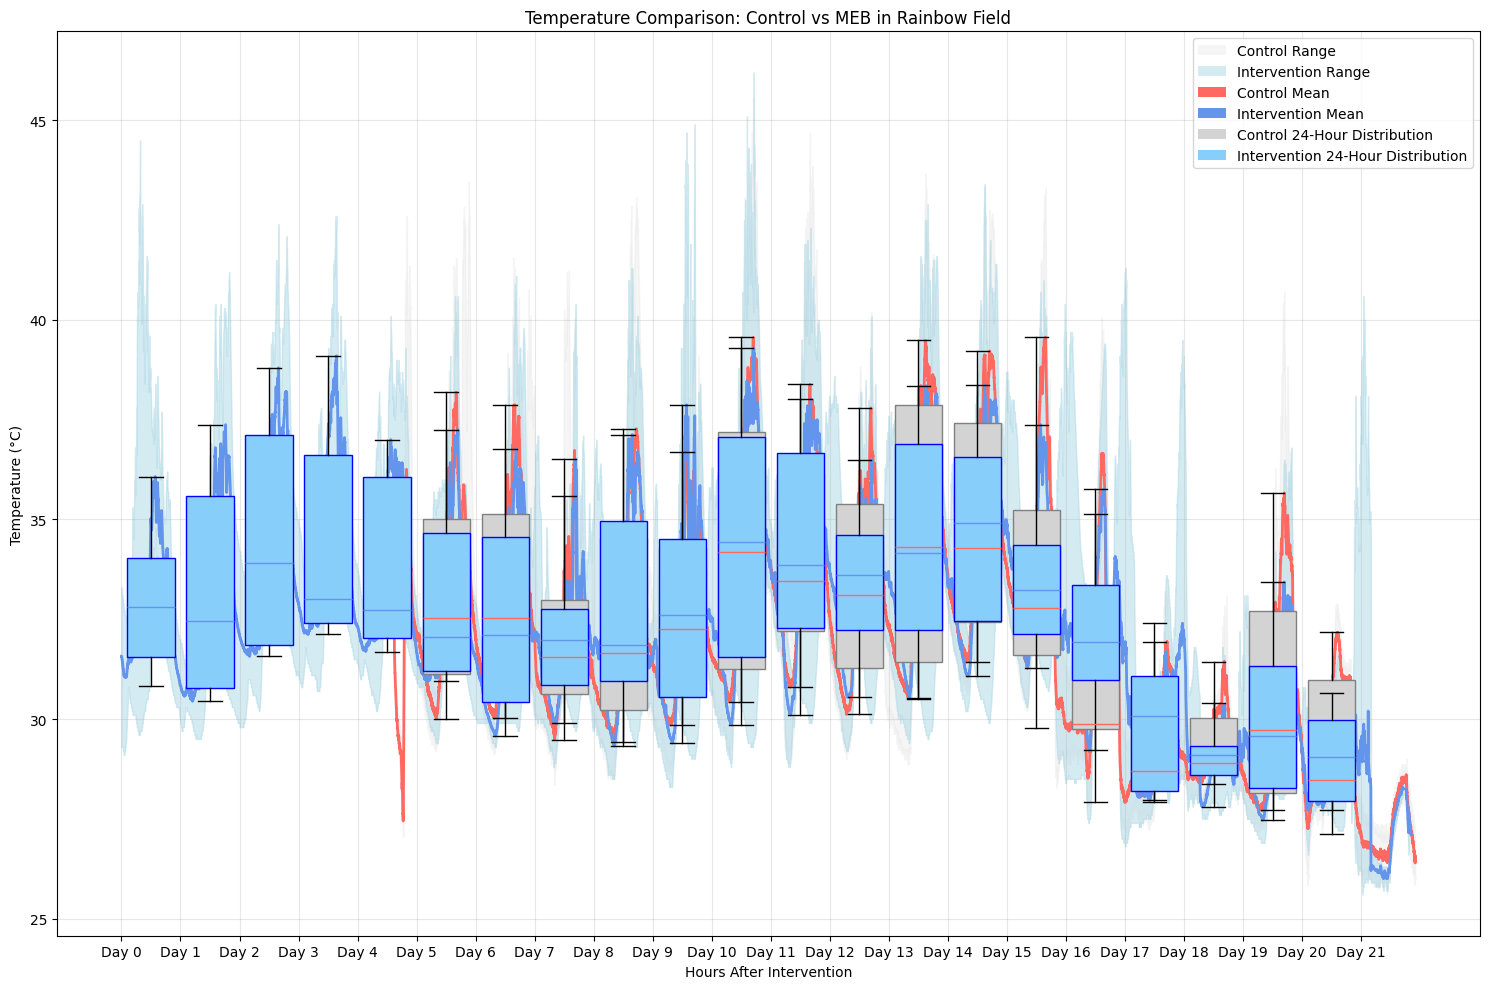

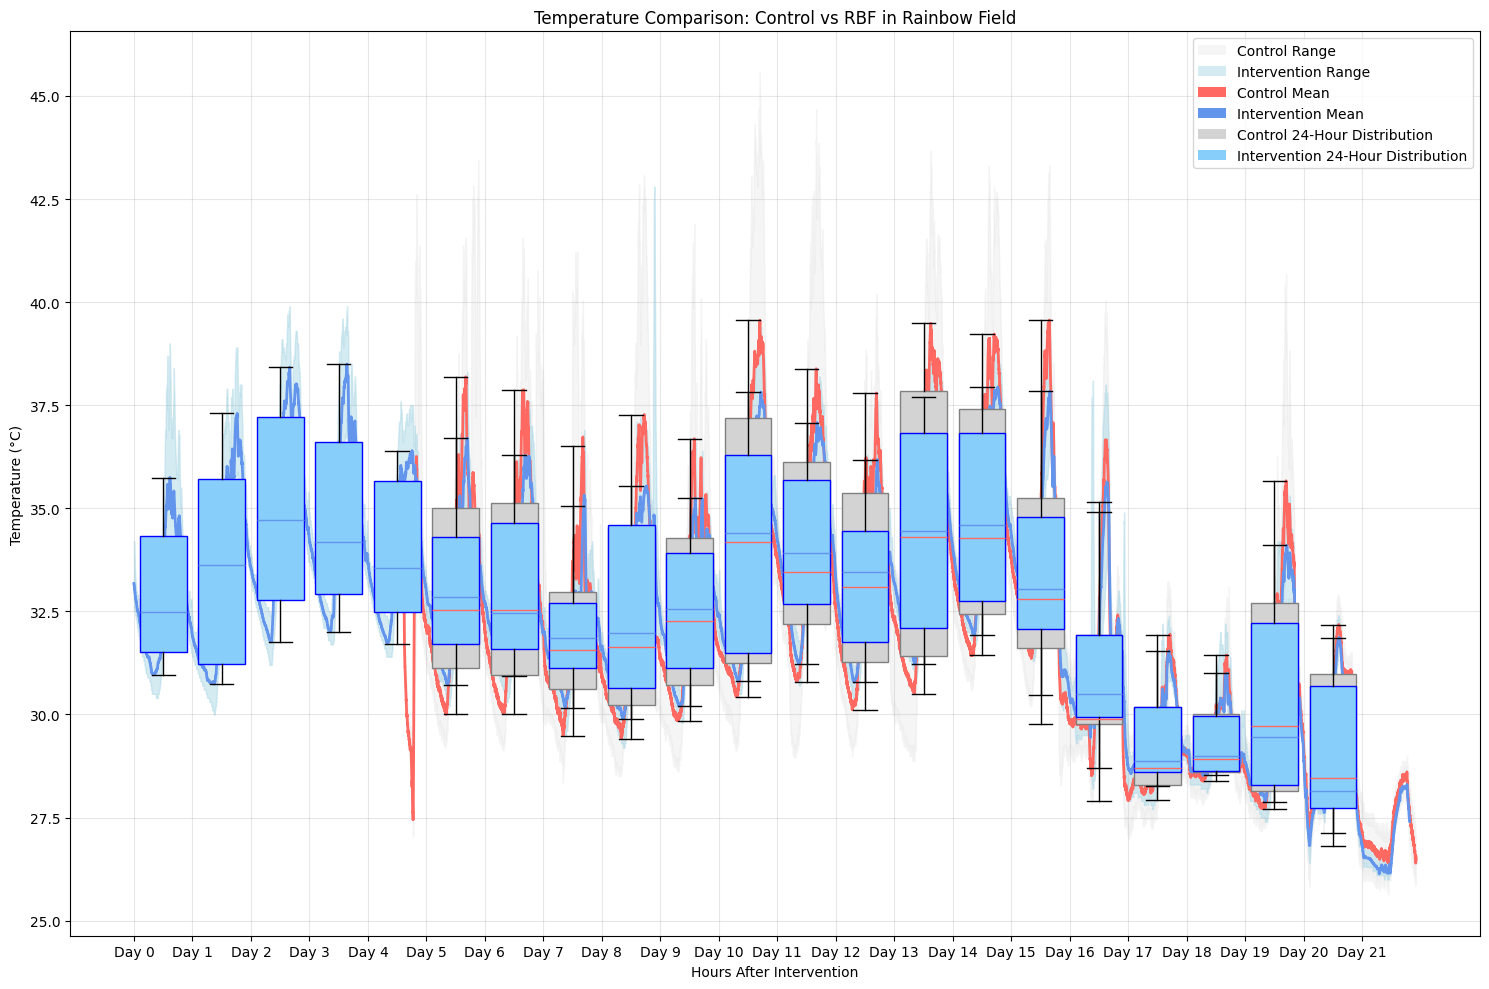

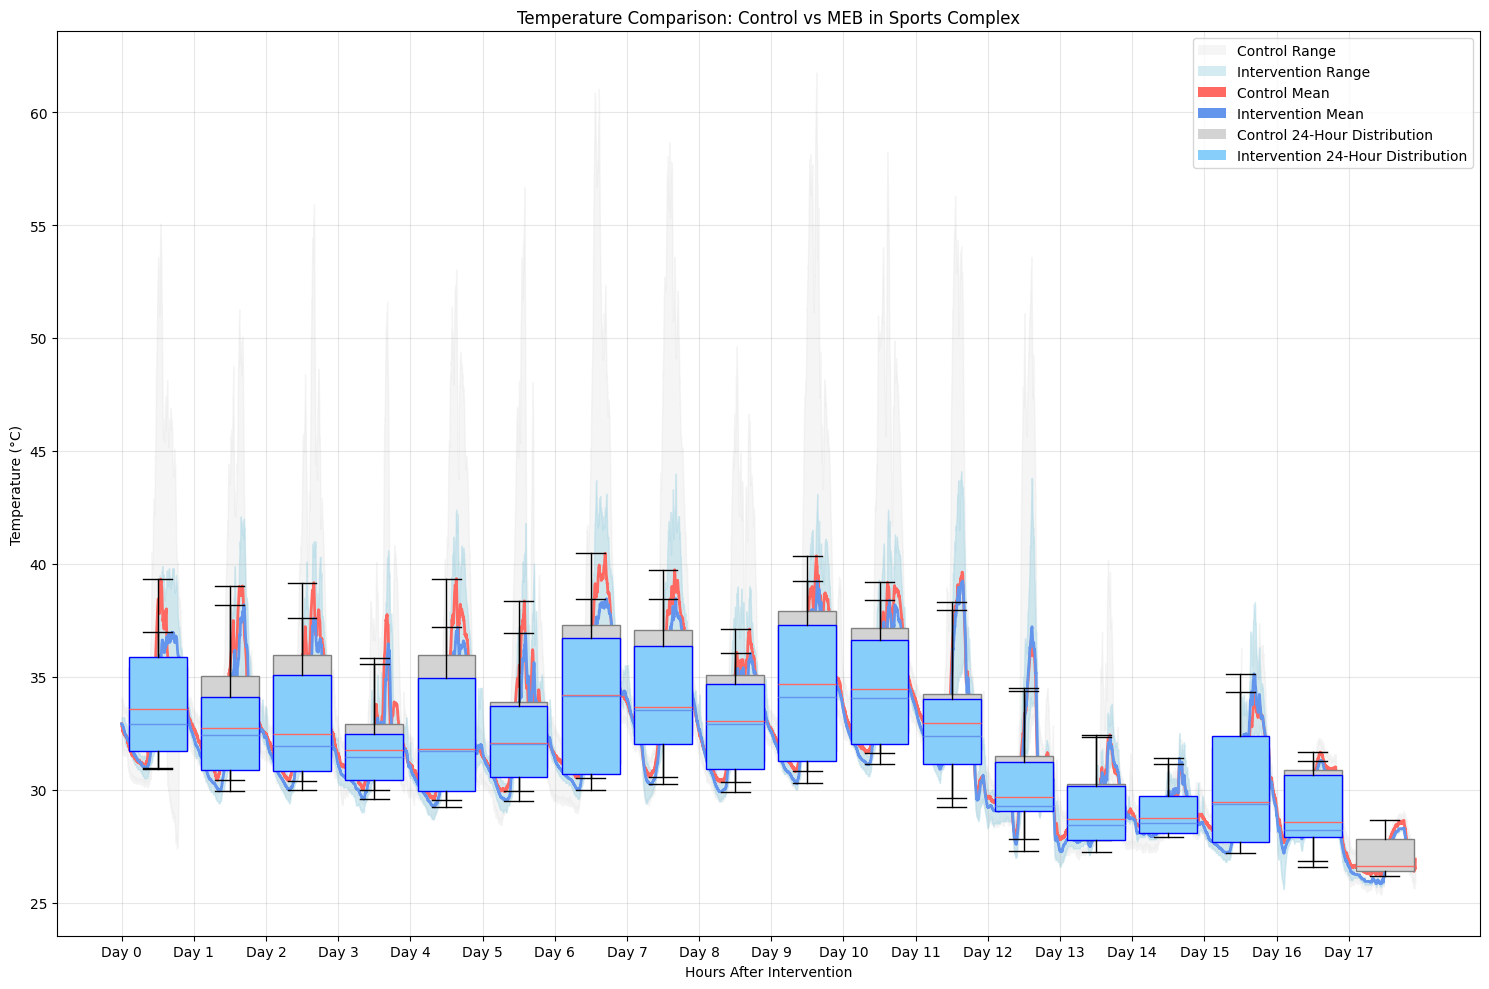

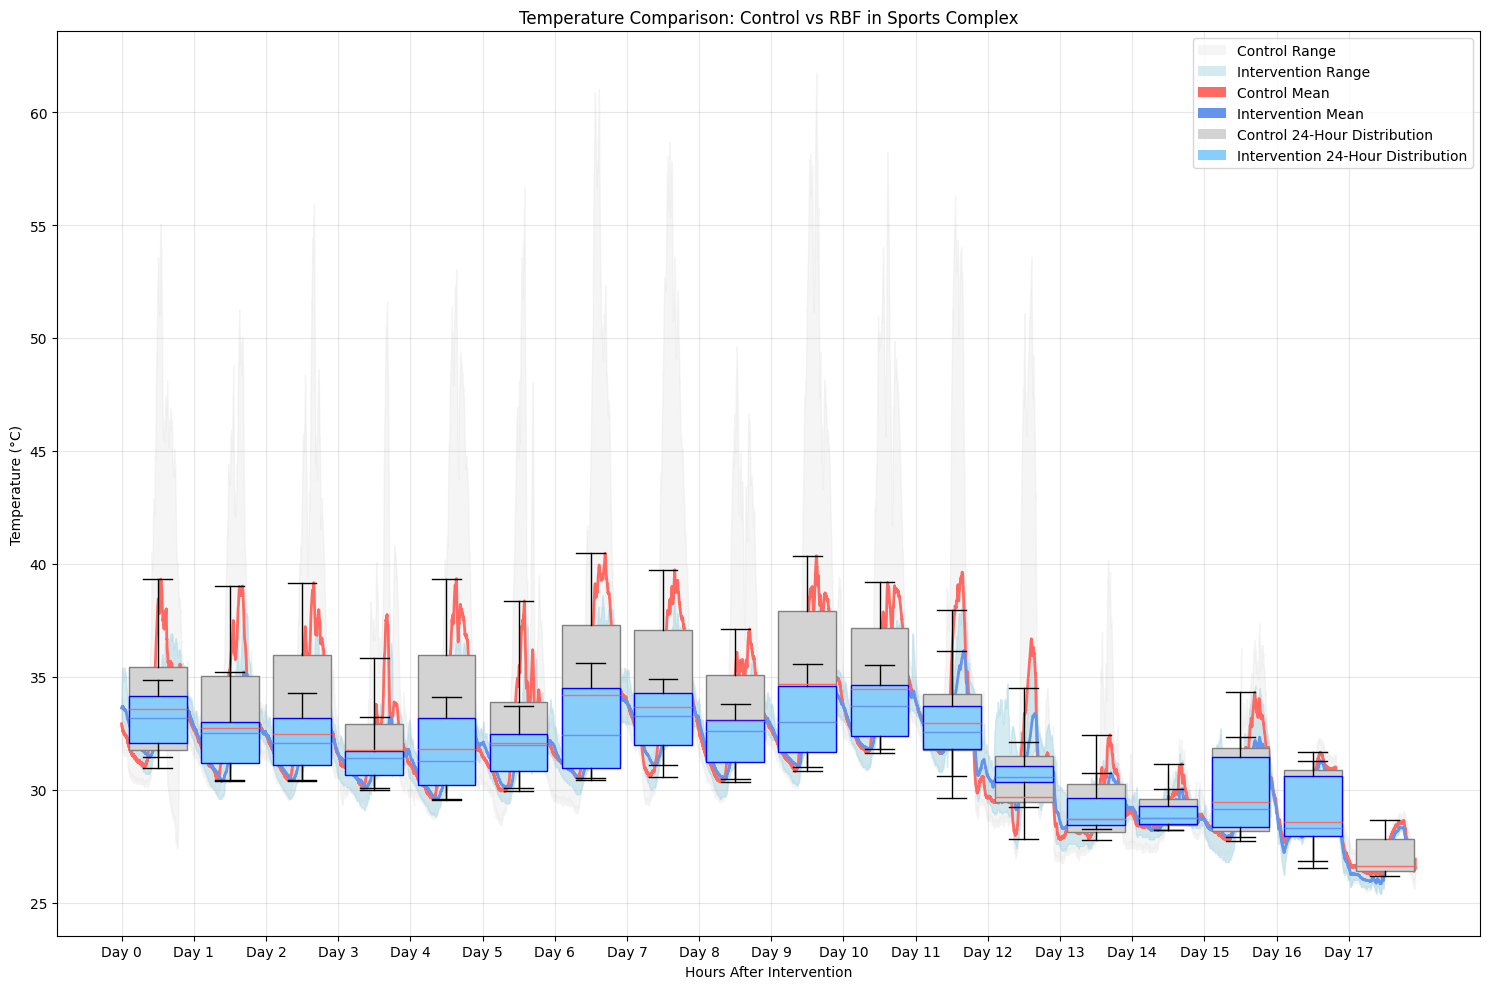

In [2]:
import pandas as pd
import numpy.ma as ma
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

def create_hourly_comparison_plot(
    settlement, 
    intervention_type='MEB', 
    hour_distribution=2,
    colors=None
):
    """
    Create comparison plot with configurable hour distribution and colors for box plots
    
    Parameters:
    -----------
    settlement : str
        Name of the settlement
    intervention_type : str
        Type of intervention (default: 'MEB')
    hour_distribution : int
        Number of hours to group for each box plot (default: 2)
        Examples: 2 for 2-hour distribution, 6 for 6-hour, 24 for daily
    colors : dict, optional
        Dictionary to customize plot colors. Supports the following keys:
        - 'control_range': color for control range fill (default: 'lightgray')
        - 'intervention_range': color for intervention range fill (default: 'lightblue')
        - 'control_mean': color for control mean line (default: 'red')
        - 'intervention_mean': color for intervention mean line (default: 'blue')
        - 'control_box': color for control box (default: 'lightgray')
        - 'intervention_box': color for intervention box (default: 'lightblue')
    """
    default_colors = {
        'control_range': 'lightgray',
        'intervention_range': 'lightblue',
        'control_mean': 'red',
        'intervention_mean': 'blue',
        'control_box': 'lightgray',
        'intervention_box': 'lightblue'
    }
    
    if colors is not None:
        default_colors.update(colors)
    
    master_df = pd.read_csv('master_dataframe.csv', parse_dates=['DateTime'])
    logger_flags_df = pd.read_csv('logger_flags.csv')

    control_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) & 
        (logger_flags_df['Intervention'] == 'CONTROL')
    ]['Loggers'].tolist()
    
    intervention_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) & 
        (logger_flags_df['Intervention'] == intervention_type)
    ]['Loggers'].tolist()

    intervention_start = pd.to_datetime(
        logger_flags_df[
            (logger_flags_df['Settlement'] == settlement) & 
            (logger_flags_df['Intervention'] == intervention_type)
        ]['Intervention_Start'].iloc[0]
    )

    master_df['DateTime'] = pd.to_datetime(master_df['DateTime'])
    post_intervention_df = master_df[master_df['DateTime'] >= intervention_start].copy()
    post_intervention_df['Hours_After_Intervention'] = (
        post_intervention_df['DateTime'] - intervention_start
    ).dt.total_seconds() / 3600

    def calculate_hourly_stats(loggers, df):
        hourly_stats = pd.DataFrame()
        logger_data = df[loggers]
        hourly_stats['max'] = logger_data.max(axis=1)
        hourly_stats['min'] = logger_data.min(axis=1)
        hourly_stats['mean'] = logger_data.mean(axis=1)
        hourly_stats['std'] = logger_data.std(axis=1)
        hourly_stats['Hours_After_Intervention'] = df['Hours_After_Intervention']
        return hourly_stats

    control_stats = calculate_hourly_stats(control_loggers, post_intervention_df)
    intervention_stats = calculate_hourly_stats(intervention_loggers, post_intervention_df)

    fig, ax = plt.subplots(figsize=(15, 10))

    control_range = ax.fill_between(control_stats['Hours_After_Intervention'],
                                  control_stats['max'],
                                  control_stats['min'],
                                  alpha=0.3,
                                  color=default_colors['control_range'],
                                  label='Control Range')

    intervention_range = ax.fill_between(intervention_stats['Hours_After_Intervention'],
                                       intervention_stats['max'],
                                       intervention_stats['min'],
                                       alpha=0.5,
                                       color=default_colors['intervention_range'],
                                       label='Intervention Range')

    control_mean, = ax.plot(control_stats['Hours_After_Intervention'],
                          control_stats['mean'],
                          color=default_colors['control_mean'],
                          label='Control Mean',
                          linewidth=2)
    
    intervention_mean, = ax.plot(intervention_stats['Hours_After_Intervention'],
                               intervention_stats['mean'],
                               color=default_colors['intervention_mean'],
                               label='Intervention Mean',
                               linewidth=2)

    control_boxes = []
    intervention_boxes = []

    box_width = hour_distribution * 0.8
    max_hours = max(control_stats['Hours_After_Intervention'])
    
    for hour in np.arange(0, max_hours, hour_distribution):
        control_period = control_stats[
            (control_stats['Hours_After_Intervention'] >= hour) & 
            (control_stats['Hours_After_Intervention'] < hour + hour_distribution)
        ]
        intervention_period = intervention_stats[
            (intervention_stats['Hours_After_Intervention'] >= hour) & 
            (intervention_stats['Hours_After_Intervention'] < hour + hour_distribution)
        ]

        if len(control_period) > 0:
            control_box = ax.boxplot(control_period['mean'],
                                   positions=[hour + hour_distribution/2],
                                   widths=box_width,
                                   patch_artist=True,
                                   boxprops=dict(facecolor=default_colors['control_box'], color='gray'),
                                   medianprops=dict(color=default_colors['control_mean']),
                                   showfliers=False)
            control_boxes.append(control_box)
            
        if len(intervention_period) > 0:
            intervention_box = ax.boxplot(intervention_period['mean'],
                                        positions=[hour + hour_distribution/2],
                                        widths=box_width,
                                        patch_artist=True,
                                        boxprops=dict(facecolor=default_colors['intervention_box'], color='blue'),
                                        medianprops=dict(color=default_colors['intervention_mean']),
                                        showfliers=False)
            intervention_boxes.append(intervention_box)

    distribution_label = f'{hour_distribution}-Hour Distribution'
    legend_elements = [
        (Patch(facecolor=default_colors['control_range'], alpha=0.3), [control_range], 'Control Range'),
        (Patch(facecolor=default_colors['intervention_range'], alpha=0.5), [intervention_range], 'Intervention Range'),
        (Patch(facecolor=default_colors['control_mean']), [control_mean], 'Control Mean'),
        (Patch(facecolor=default_colors['intervention_mean']), [intervention_mean], 'Intervention Mean'),
        (Patch(facecolor=default_colors['control_box'], alpha=1.0), 
         control_boxes, 
         f'Control {distribution_label}'),
        (Patch(facecolor=default_colors['intervention_box'], alpha=1.0), 
         intervention_boxes, 
         f'Intervention {distribution_label}')
    ]

    leg = ax.legend([item[0] for item in legend_elements],
                   [item[2] for item in legend_elements],
                   loc='upper right')

    lined = {}
    for legpatch, elements, label in legend_elements:
        legline = leg.get_patches()[legend_elements.index((legpatch, elements, label))]
        if distribution_label in label:
            lined[legline] = elements
        else:
            lined[legline] = elements

    def on_pick(event):
        legline = event.artist
        if legline in lined:
            elements = lined[legline]
            
            if isinstance(elements[0], dict): 
                visible = not any(box['boxes'][0].get_visible() for box in elements)
                for box in elements:
                    for component in box.values():
                        for artist in component:
                            artist.set_visible(visible)
            else:
                visible = not elements[0].get_visible()
                for element in elements:
                    element.set_visible(visible)
            
            legline.set_alpha(1.0 if visible else 0.2)
            fig.canvas.draw()

    for legline in leg.get_patches():
        legline.set_picker(True)

    fig.canvas.mpl_connect('pick_event', on_pick)

    ax.set_xlabel('Hours After Intervention')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title(f'Temperature Comparison: Control vs {intervention_type} in {settlement}')

    xticks = np.arange(0, max_hours, 24)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f'Day {int(x/24)}' for x in xticks])
    
    minor_xticks = np.arange(0, max_hours, hour_distribution)
    ax.set_xticks(minor_xticks, minor=True)

    ax.grid(True, alpha=0.3)
    ax.grid(True, which='minor', alpha=0.1)
    plt.tight_layout()
    plt.show()

settlements = ['Rainbow Field', 'Sports Complex']
intervention_types = ['MEB', 'RBF']

# Change this value to adjust hour distribution like 2, 6, 24, etc.
hour_distribution = 24 

custom_colors = {
    'control_range': '#E0E0E0',  # Light gray
    'intervention_range': '#ADD8E6',  # Light blue
    'control_mean': '#FF6961',  # Soft red
    'intervention_mean': '#6495ED',  # Cornflower blue
    'control_box': '#D3D3D3',  # Light gray
    'intervention_box': '#87CEFA'  # Light sky blue
}

for settlement in settlements:
    for intervention_type in intervention_types:
        create_hourly_comparison_plot(
            settlement, 
            intervention_type, 
            hour_distribution,
            colors=custom_colors
        )

In [ ]:
import pandas as pd
import numpy.ma as ma
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

def create_day_night_comparison_plots(
    settlement, 
    intervention_type='MEB', 
    hour_distribution=2,
    colors=None
):
    """
    Create separate day and night comparison plots
    
    Parameters:
    -----------
    settlement : str
        Name of the settlement
    intervention_type : str
        Type of intervention (default: 'MEB')
    hour_distribution : int
        Number of hours to group for each box plot
    colors : dict, optional
        Dictionary to customize plot colors
    """
    default_colors = {
        'control_range': 'lightgray',
        'intervention_range': 'lightblue',
        'control_mean': 'red',
        'intervention_mean': 'blue',
        'control_box': 'lightgray',
        'intervention_box': 'lightblue'
    }
    
    if colors is not None:
        default_colors.update(colors)
    
    master_df = pd.read_csv('master_dataframe.csv', parse_dates=['DateTime'])
    logger_flags_df = pd.read_csv('logger_flags.csv')

    control_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) & 
        (logger_flags_df['Intervention'] == 'CONTROL')
    ]['Loggers'].tolist()
    
    intervention_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) & 
        (logger_flags_df['Intervention'] == intervention_type)
    ]['Loggers'].tolist()

    intervention_start = pd.to_datetime(
        logger_flags_df[
            (logger_flags_df['Settlement'] == settlement) & 
            (logger_flags_df['Intervention'] == intervention_type)
        ]['Intervention_Start'].iloc[0]
    )

    master_df['DateTime'] = pd.to_datetime(master_df['DateTime'])
    post_intervention_df = master_df[master_df['DateTime'] >= intervention_start].copy()
    post_intervention_df['Hours_After_Intervention'] = (
        post_intervention_df['DateTime'] - intervention_start
    ).dt.total_seconds() / 3600
    
    # Split into day and night
    post_intervention_df['Hour'] = post_intervention_df['DateTime'].dt.hour
    day_df = post_intervention_df[
        (post_intervention_df['Hour'] >= 6) & 
        (post_intervention_df['Hour'] < 19)
    ].copy()
    night_df = post_intervention_df[
        (post_intervention_df['Hour'] < 6) | 
        (post_intervention_df['Hour'] >= 19)
    ].copy()

    def calculate_hourly_stats(loggers, df):
        hourly_stats = pd.DataFrame()
        logger_data = df[loggers]
        hourly_stats['max'] = logger_data.max(axis=1)
        hourly_stats['min'] = logger_data.min(axis=1)
        hourly_stats['mean'] = logger_data.mean(axis=1)
        hourly_stats['std'] = logger_data.std(axis=1)
        hourly_stats['Hours_After_Intervention'] = df['Hours_After_Intervention']
        return hourly_stats

    def create_plot(data_df, period):
        control_stats = calculate_hourly_stats(control_loggers, data_df)
        intervention_stats = calculate_hourly_stats(intervention_loggers, data_df)

        fig, ax = plt.subplots(figsize=(15, 8))

        control_range = ax.fill_between(
            control_stats['Hours_After_Intervention'],
            control_stats['max'],
            control_stats['min'],
            alpha=0.3,
            color=default_colors['control_range'],
            label='Control Range'
        )

        intervention_range = ax.fill_between(
            intervention_stats['Hours_After_Intervention'],
            intervention_stats['max'],
            intervention_stats['min'],
            alpha=0.5,
            color=default_colors['intervention_range'],
            label='Intervention Range'
        )

        control_mean, = ax.plot(
            control_stats['Hours_After_Intervention'],
            control_stats['mean'],
            color=default_colors['control_mean'],
            label='Control Mean',
            linewidth=2
        )
        
        intervention_mean, = ax.plot(
            intervention_stats['Hours_After_Intervention'],
            intervention_stats['mean'],
            color=default_colors['intervention_mean'],
            label='Intervention Mean',
            linewidth=2
        )

        control_boxes = []
        intervention_boxes = []

        box_width = hour_distribution * 0.8
        max_hours = max(control_stats['Hours_After_Intervention'])
        
        for hour in np.arange(0, max_hours, hour_distribution):
            control_period = control_stats[
                (control_stats['Hours_After_Intervention'] >= hour) & 
                (control_stats['Hours_After_Intervention'] < hour + hour_distribution)
            ]
            intervention_period = intervention_stats[
                (intervention_stats['Hours_After_Intervention'] >= hour) & 
                (intervention_stats['Hours_After_Intervention'] < hour + hour_distribution)
            ]

            if len(control_period) > 0:
                control_box = ax.boxplot(
                    control_period['mean'],
                    positions=[hour + hour_distribution/2],
                    widths=box_width,
                    patch_artist=True,
                    boxprops=dict(facecolor=default_colors['control_box'], color='gray'),
                    medianprops=dict(color=default_colors['control_mean']),
                    showfliers=False
                )
                control_boxes.append(control_box)
                
            if len(intervention_period) > 0:
                intervention_box = ax.boxplot(
                    intervention_period['mean'],
                    positions=[hour + hour_distribution/2],
                    widths=box_width,
                    patch_artist=True,
                    boxprops=dict(facecolor=default_colors['intervention_box'], color='blue'),
                    medianprops=dict(color=default_colors['intervention_mean']),
                    showfliers=False
                )
                intervention_boxes.append(intervention_box)

        distribution_label = f'{hour_distribution}-Hour Distribution'
        legend_elements = [
            (Patch(facecolor=default_colors['control_range'], alpha=0.3), [control_range], 'Control Range'),
            (Patch(facecolor=default_colors['intervention_range'], alpha=0.5), [intervention_range], 'Intervention Range'),
            (Patch(facecolor=default_colors['control_mean']), [control_mean], 'Control Mean'),
            (Patch(facecolor=default_colors['intervention_mean']), [intervention_mean], 'Intervention Mean'),
            (Patch(facecolor=default_colors['control_box'], alpha=1.0), 
             control_boxes, 
             f'Control {distribution_label}'),
            (Patch(facecolor=default_colors['intervention_box'], alpha=1.0), 
             intervention_boxes, 
             f'Intervention {distribution_label}')
        ]

        leg = ax.legend([item[0] for item in legend_elements],
                       [item[2] for item in legend_elements],
                       loc='upper right')

        lined = {}
        for legpatch, elements, label in legend_elements:
            legline = leg.get_patches()[legend_elements.index((legpatch, elements, label))]
            if distribution_label in label:
                lined[legline] = elements
            else:
                lined[legline] = elements

        def on_pick(event):
            legline = event.artist
            if legline in lined:
                elements = lined[legline]
                
                if isinstance(elements[0], dict): 
                    visible = not any(box['boxes'][0].get_visible() for box in elements)
                    for box in elements:
                        for component in box.values():
                            for artist in component:
                                artist.set_visible(visible)
                else:
                    visible = not elements[0].get_visible()
                    for element in elements:
                        element.set_visible(visible)
                
                legline.set_alpha(1.0 if visible else 0.2)
                fig.canvas.draw()

        for legline in leg.get_patches():
            legline.set_picker(True)

        fig.canvas.mpl_connect('pick_event', on_pick)

        ax.set_xlabel('Hours After Intervention')
        ax.set_ylabel('Temperature (°C)')
        ax.set_title(f'{period} Temperature Comparison: Control vs {intervention_type} in {settlement}\n')

        xticks = np.arange(0, max_hours, 24)
        ax.set_xticks(xticks)
        ax.set_xticklabels([f'Day {int(x/24)}' for x in xticks])
        
        minor_xticks = np.arange(0, max_hours, hour_distribution)
        ax.set_xticks(minor_xticks, minor=True)

        ax.grid(True, alpha=0.3)
        ax.grid(True, which='minor', alpha=0.1)
        plt.tight_layout()
        
        # Add time period annotation
        if period == "Day":
            time_text = "6 AM - 7 PM"
        else:
            time_text = "7 PM - 6 AM"
        plt.figtext(0.02, 0.98, f"Time period: {time_text}", fontsize=10, ha='left', va='top')
        
        plt.show()

    # Create separate plots for day and night
    create_plot(day_df, "Day")
    create_plot(night_df, "Night")

# Example usage
settlements = ['Rainbow Field', 'Sports Complex']
intervention_types = ['MEB', 'RBF']
hour_distribution = 24  # Change this value to adjust hour distribution

custom_colors = {
    'control_range': '#E0E0E0',  # Light gray
    'intervention_range': '#ADD8E6',  # Light blue
    'control_mean': '#FF6961',  # Soft red
    'intervention_mean': '#6495ED',  # Cornflower blue
    'control_box': '#D3D3D3',  # Light gray
    'intervention_box': '#87CEFA'  # Light sky blue
}

for settlement in settlements:
    for intervention_type in intervention_types:
        create_day_night_comparison_plots(
            settlement, 
            intervention_type, 
            hour_distribution,
            colors=custom_colors
        )

In [ ]:
import pandas as pd
import numpy.ma as ma
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

def create_day_night_comparison_plots(
    settlement, 
    intervention_type='MEB', 
    hour_distribution=2,
    colors=None
):
    """
    Create separate day and night comparison plots
    
    Parameters:
    -----------
    settlement : str
        Name of the settlement
    intervention_type : str
        Type of intervention (default: 'MEB')
    hour_distribution : int
        Number of hours to group for each box plot
    colors : dict, optional
        Dictionary to customize plot colors
    """
    default_colors = {
        'control_range': 'lightgray',
        'intervention_range': 'lightblue',
        'control_mean': 'red',
        'intervention_mean': 'blue',
        'control_box': 'lightgray',
        'intervention_box': 'lightblue'
    }
    
    if colors is not None:
        default_colors.update(colors)
    
    master_df = pd.read_csv('master_dataframe.csv', parse_dates=['DateTime'])
    logger_flags_df = pd.read_csv('logger_flags.csv')

    control_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) & 
        (logger_flags_df['Intervention'] == 'CONTROL')
    ]['Loggers'].tolist()
    
    intervention_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) & 
        (logger_flags_df['Intervention'] == intervention_type)
    ]['Loggers'].tolist()

    intervention_start = pd.to_datetime(
        logger_flags_df[
            (logger_flags_df['Settlement'] == settlement) & 
            (logger_flags_df['Intervention'] == intervention_type)
        ]['Intervention_Start'].iloc[0]
    )

    master_df['DateTime'] = pd.to_datetime(master_df['DateTime'])
    post_intervention_df = master_df[master_df['DateTime'] >= intervention_start].copy()
    post_intervention_df['Hours_After_Intervention'] = (
        post_intervention_df['DateTime'] - intervention_start
    ).dt.total_seconds() / 3600
    
    # Split into day and night
    post_intervention_df['Hour'] = post_intervention_df['DateTime'].dt.hour
    day_df = post_intervention_df[
        (post_intervention_df['Hour'] >= 6) & 
        (post_intervention_df['Hour'] < 19)
    ].copy()
    night_df = post_intervention_df[
        (post_intervention_df['Hour'] < 6) | 
        (post_intervention_df['Hour'] >= 19)
    ].copy()

    def calculate_hourly_stats(loggers, df):
        hourly_stats = pd.DataFrame()
        logger_data = df[loggers]
        hourly_stats['max'] = logger_data.max(axis=1)
        hourly_stats['min'] = logger_data.min(axis=1)
        hourly_stats['mean'] = logger_data.mean(axis=1)
        hourly_stats['std'] = logger_data.std(axis=1)
        hourly_stats['Hours_After_Intervention'] = df['Hours_After_Intervention']
        return hourly_stats

    def create_plot(data_df, period):
        control_stats = calculate_hourly_stats(control_loggers, data_df)
        intervention_stats = calculate_hourly_stats(intervention_loggers, data_df)

        fig, ax = plt.subplots(figsize=(15, 8))

        control_range = ax.fill_between(
            control_stats['Hours_After_Intervention'],
            control_stats['max'],
            control_stats['min'],
            alpha=0.3,
            color=default_colors['control_range'],
            label='Control Range'
        )

        intervention_range = ax.fill_between(
            intervention_stats['Hours_After_Intervention'],
            intervention_stats['max'],
            intervention_stats['min'],
            alpha=0.5,
            color=default_colors['intervention_range'],
            label='Intervention Range'
        )

        control_mean, = ax.plot(
            control_stats['Hours_After_Intervention'],
            control_stats['mean'],
            color=default_colors['control_mean'],
            label='Control Mean',
            linewidth=2
        )
        
        intervention_mean, = ax.plot(
            intervention_stats['Hours_After_Intervention'],
            intervention_stats['mean'],
            color=default_colors['intervention_mean'],
            label='Intervention Mean',
            linewidth=2
        )

        control_boxes = []
        intervention_boxes = []

        box_width = hour_distribution * 0.8
        max_hours = max(control_stats['Hours_After_Intervention'])
        
        for hour in np.arange(0, max_hours, hour_distribution):
            control_period = control_stats[
                (control_stats['Hours_After_Intervention'] >= hour) & 
                (control_stats['Hours_After_Intervention'] < hour + hour_distribution)
            ]
            intervention_period = intervention_stats[
                (intervention_stats['Hours_After_Intervention'] >= hour) & 
                (intervention_stats['Hours_After_Intervention'] < hour + hour_distribution)
            ]

            if len(control_period) > 0:
                control_box = ax.boxplot(
                    control_period['mean'],
                    positions=[hour + hour_distribution/2],
                    widths=box_width,
                    patch_artist=True,
                    boxprops=dict(facecolor=default_colors['control_box'], color='gray'),
                    medianprops=dict(color=default_colors['control_mean']),
                    showfliers=False
                )
                control_boxes.append(control_box)
                
            if len(intervention_period) > 0:
                intervention_box = ax.boxplot(
                    intervention_period['mean'],
                    positions=[hour + hour_distribution/2],
                    widths=box_width,
                    patch_artist=True,
                    boxprops=dict(facecolor=default_colors['intervention_box'], color='blue'),
                    medianprops=dict(color=default_colors['intervention_mean']),
                    showfliers=False
                )
                intervention_boxes.append(intervention_box)

        distribution_label = f'{hour_distribution}-Hour Distribution'
        legend_elements = [
            (Patch(facecolor=default_colors['control_range'], alpha=0.3), [control_range], 'Control Range'),
            (Patch(facecolor=default_colors['intervention_range'], alpha=0.5), [intervention_range], 'Intervention Range'),
            (Patch(facecolor=default_colors['control_mean']), [control_mean], 'Control Mean'),
            (Patch(facecolor=default_colors['intervention_mean']), [intervention_mean], 'Intervention Mean'),
            (Patch(facecolor=default_colors['control_box'], alpha=1.0), 
             control_boxes, 
             f'Control {distribution_label}'),
            (Patch(facecolor=default_colors['intervention_box'], alpha=1.0), 
             intervention_boxes, 
             f'Intervention {distribution_label}')
        ]

        leg = ax.legend([item[0] for item in legend_elements],
                       [item[2] for item in legend_elements],
                       loc='upper right')

        lined = {}
        for legpatch, elements, label in legend_elements:
            legline = leg.get_patches()[legend_elements.index((legpatch, elements, label))]
            if distribution_label in label:
                lined[legline] = elements
            else:
                lined[legline] = elements

        def on_pick(event):
            legline = event.artist
            if legline in lined:
                elements = lined[legline]
                
                if isinstance(elements[0], dict): 
                    visible = not any(box['boxes'][0].get_visible() for box in elements)
                    for box in elements:
                        for component in box.values():
                            for artist in component:
                                artist.set_visible(visible)
                else:
                    visible = not elements[0].get_visible()
                    for element in elements:
                        element.set_visible(visible)
                
                legline.set_alpha(1.0 if visible else 0.2)
                fig.canvas.draw()

        for legline in leg.get_patches():
            legline.set_picker(True)

        fig.canvas.mpl_connect('pick_event', on_pick)

        ax.set_xlabel('Hours After Intervention')
        ax.set_ylabel('Temperature (°C)')
        ax.set_title(f'{period} Temperature Comparison: Control vs {intervention_type} in {settlement}\n')



        def format_hour_label(hour):
            if period == "Day":
                # For day period (6 AM - 7 PM)
                actual_hour = (hour % 24) + 6  # Start from 6 AM
                if actual_hour >= 24:
                    actual_hour -= 24
            else:
                # For night period (7 PM - 6 AM)
                actual_hour = (hour % 24) + 19  # Start from 7 PM
                if actual_hour >= 24:
                    actual_hour -= 24
            return f"{int(actual_hour):02d}:00"

        xticks_major = np.arange(0, max_hours, 24)
        ax.set_xticks(xticks_major)
        ax.set_xticklabels([f'Day {int(x/24)}' for x in xticks_major])

        plt.setp(ax.get_xticklabels(), rotation=90, ha='right')

        if period == "Day":
            hours_in_day = 13  # 6 AM to 7 PM = 13 hours
            xticks_minor = np.arange(0, max_hours, hour_distribution)
            xticks_minor = xticks_minor[xticks_minor % 24 < hours_in_day]
        else:
            hours_in_night = 11  # 7 PM to 6 AM = 11 hours
            xticks_minor = np.arange(0, max_hours, hour_distribution)
            xticks_minor = xticks_minor[xticks_minor % 24 >= hours_in_night]

        ax.set_xticks(xticks_minor, minor=True)

        minor_labels = [format_hour_label(h) for h in xticks_minor]
        ax.set_xticklabels(minor_labels, minor=True)

        plt.setp(ax.get_xticklabels(minor=True), rotation=90, ha='right')

        plt.subplots_adjust(bottom=0.2)

        if period == "Day":
            time_text = "6 AM - 7 PM"
        else:
            time_text = "7 PM - 6 AM"
        plt.figtext(0.02, 0.98, f"Time period: {time_text}", fontsize=10, ha='left', va='top')

        # Add grid
        ax.grid(True, alpha=0.3)
        ax.grid(True, which='minor', alpha=0.1)

        plt.tight_layout()
        plt.show()

    create_plot(day_df, "Day")
    create_plot(night_df, "Night")

settlements = ['Rainbow Field', 'Sports Complex']
intervention_types = ['MEB', 'RBF']
hour_distribution = 6  # Change this value to adjust hour distribution

custom_colors = {
    'control_range': '#E0E0E0',  # Light gray
    'intervention_range': '#ADD8E6',  # Light blue
    'control_mean': '#FF6961',  # Soft red
    'intervention_mean': '#6495ED',  # Cornflower blue
    'control_box': '#D3D3D3',  # Light gray
    'intervention_box': '#87CEFA'  # Light sky blue
}

for settlement in settlements:
    for intervention_type in intervention_types:
        create_day_night_comparison_plots(
            settlement, 
            intervention_type, 
            hour_distribution,
            colors=custom_colors
        )